In [1]:
import pandas as pd

INPUT_PATH = "../clustering/intermediate_data/clustered_embeddings.csv"
OUTPUT_PATH = "./progress_added.csv"
NUM_CLASSES = 10
MODE = "classifier"


def time_to_seconds(t):
    """Convert MM:SS or HH:MM:SS to seconds"""
    parts = list(map(int, t.split(":")))
    if len(parts) == 2:
        return parts[0] * 60 + parts[1]
    elif len(parts) == 3:
        return parts[0] * 3600 + parts[1] * 60 + parts[2]
    else:
        return 0

def extract_start_end_sec(row):
    """Parse row['start'] and row['end'] into seconds"""
    start_sec = time_to_seconds(row["start"])
    end_sec = time_to_seconds(row["end"])
    return start_sec, end_sec


df = pd.read_csv(INPUT_PATH)
df = df[df["text"].notnull() & df["text"].str.strip().astype(bool)]
print(f"Loaded {len(df)} rows")

df[["start_sec", "end_sec"]] = df.apply(lambda row: pd.Series(extract_start_end_sec(row)), axis=1)

progress_labels = []


for file_name, group in df.groupby("file"):
    total_duration = group["end_sec"].max()
    print(f"\nFile {file_name}: total duration {total_duration:.1f} sec")

    for i, row in group.iterrows():
        center_time = (row["start_sec"] + row["end_sec"]) / 2
        progress_frac = center_time / total_duration  # 0.0 - 1.0

        if MODE == "classifier":
            # map to class 0 .. NUM_CLASSES-1
            class_size = 1.0 / NUM_CLASSES
            progress_class = int(progress_frac / class_size)

            if progress_class >= NUM_CLASSES:
                progress_class = NUM_CLASSES - 1  # handle edge

            progress_labels.append(progress_class)

        elif MODE == "regression":
            # keep raw progress (float between 0.0 - 1.0)
            progress_labels.append(progress_frac)

df["progress_label"] = progress_labels

df.to_csv(OUTPUT_PATH, index=False)
print(f"\nOK: saved {len(df)} rows to {OUTPUT_PATH}")

Loaded 3474 rows

File 210.json: total duration 3648.0 sec

File 211.json: total duration 3242.0 sec

File 212.json: total duration 2447.0 sec

File 213.json: total duration 2759.0 sec

File 214.json: total duration 1626.0 sec

File 215.json: total duration 2193.0 sec

File 216.json: total duration 3062.0 sec

File 217.json: total duration 1761.0 sec

File 218.json: total duration 1574.0 sec

File 219.json: total duration 2783.0 sec

File 220.json: total duration 3593.0 sec

File 221.json: total duration 2433.0 sec

File 222.json: total duration 2152.0 sec

File 223.json: total duration 2094.0 sec

File 224.json: total duration 2461.0 sec

File 225.json: total duration 2490.0 sec

OK: saved 3474 rows to ./progress_added.csv


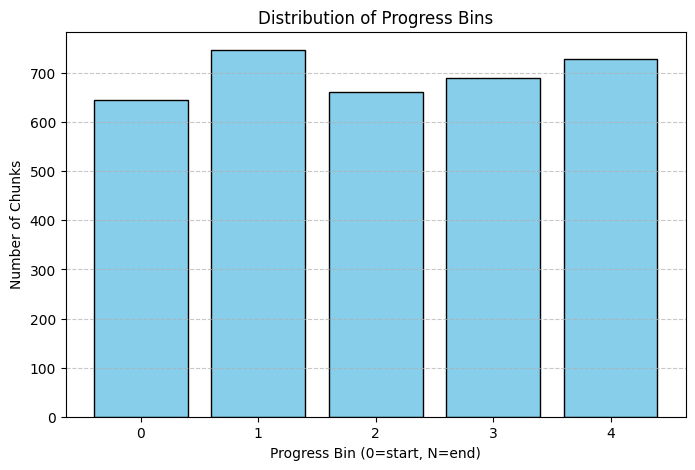

In [2]:
import matplotlib.pyplot as plt

df = pd.read_csv("./progress_added.csv")

bin_counts = df["progress_label"].value_counts().sort_index()

plt.figure(figsize=(8, 5))
plt.bar(bin_counts.index, bin_counts.values, color="skyblue", edgecolor="black")
plt.xlabel("Progress Bin (0=start, N=end)")
plt.ylabel("Number of Chunks")
plt.title("Distribution of Progress Bins")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()